In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
customer_parameters_df = pd.read_excel('Data/Customer Account Parameters.xlsx')

In [2]:
import os

csv_folder = os.path.join(os.getcwd(), "csv_outputs")
json_folder = os.path.join(os.getcwd(), "json_outputs")

In [3]:
print("Columns:", customer_parameters_df.columns.tolist())

Columns: ['CUSTOMER_NUMBER', 'PARAMETER']


In [4]:
print("Sample data:\n", customer_parameters_df.head())

Sample data:
   CUSTOMER_NUMBER  PARAMETER
0          AACJ01     Closed
1          AACJC1     Closed
2          AACJC2  Promotion
3          AAVN01     Closed
4          ABLA01     Closed


In [5]:
print("Null values:\n", customer_parameters_df.isnull().sum())

Null values:
 CUSTOMER_NUMBER    0
PARAMETER          0
dtype: int64


In [6]:
# Remove rows with any null values
customer_parameters_df = customer_parameters_df.dropna()

In [7]:
print("Data shape:", customer_parameters_df.shape)

Data shape: (1090, 2)


In [8]:
# Define semantic groups for each parameter value
group_map = {
    "Closed": "Account Status",              # Indicates inactive or terminated accounts
    "Trading Account": "Account Status",     # Indicates active, revenue-generating accounts
    "Consignment": "Operations",             # Refers to stock handling model — fits better under 'Operations'
    "Promotion": "Marketing",                # Marketing behavior — fits under 'Marketing'
    "Promotional Stand": "Retail Format"     # Physical retail setup (e.g., kiosk, pop-up) — fits under 'Retail Format'
}

# Apply semantic grouping to the parameter field
customer_parameters_df['PARAMETER_GROUP'] = customer_parameters_df['PARAMETER'].map(group_map)

customer_parameters_df.columns.tolist()


['CUSTOMER_NUMBER', 'PARAMETER', 'PARAMETER_GROUP']

In [9]:
customer_parameters_df

,CUSTOMER_NUMBER,PARAMETER,PARAMETER_GROUP
0,AACJ01,Closed,Account Status
1,AACJC1,Closed,Account Status
2,AACJC2,Promotion,Marketing
3,AAVN01,Closed,Account Status
4,ABLA01,Closed,Account Status
...,...,...,...
1085,ZDEI01,Trading Account,Account Status
1086,ZDEIOC,Consignment,Operations
1087,ZDOE02,Closed,Account Status
1088,ZHAY01,Closed,Account Status


In [10]:
'''# Extract only rows that describe account status (Closed or Trading Account)
acc_status_df = customer_parameters_df[
    customer_parameters_df['PARAMETER_GROUP'] == "Account Status"
]

acc_status_df'''

'# Extract only rows that describe account status (Closed or Trading Account)\nacc_status_df = customer_parameters_df[\n    customer_parameters_df[\'PARAMETER_GROUP\'] == "Account Status"\n]\n\nacc_status_df'

In [11]:
'''# Select rows where PARAMETER_GROUP is NOT "Account Status"
non_status_df = customer_parameters_df[customer_parameters_df['PARAMETER_GROUP'] != "Account Status"]

non_status_df'''

'# Select rows where PARAMETER_GROUP is NOT "Account Status"\nnon_status_df = customer_parameters_df[customer_parameters_df[\'PARAMETER_GROUP\'] != "Account Status"]\n\nnon_status_df'

In [12]:
# Save CSV
csv_path = os.path.join(csv_folder, "customer_params_df_clean.csv")
customer_parameters_df.to_csv(csv_path, index=False)

# Save JSON
json_path = os.path.join(json_folder, "customer_params_df_clean.json")
customer_parameters_df.to_json(json_path, orient="records", lines=True)

VISUALIZATION

<Axes: title={'center': 'Customer Distribution by Parameter Group'}, xlabel='PARAMETER_GROUP'>

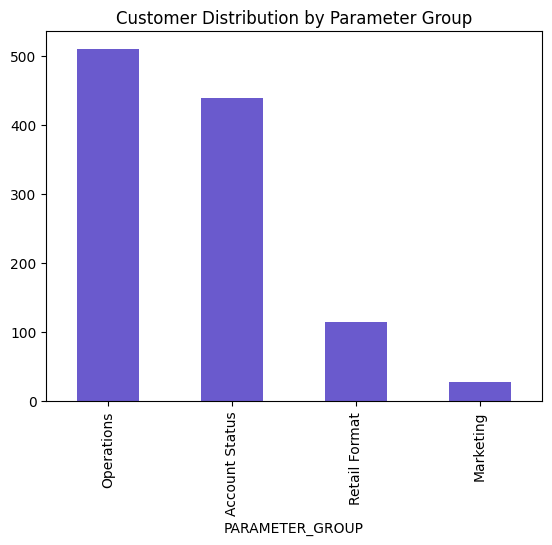

In [13]:
#Show how many customer-parameter pairs fall under each semantic group
customer_parameters_df['PARAMETER_GROUP'].value_counts().plot(
    kind='bar', color='slateblue', title='Customer Distribution by Parameter Group')